# Single asperity simulations (3D)

In this tutorial, we simulate slip on a 2D fault (within a 3D medium) with a single velocity-weakening asperity, embedded in a velocity-strengthening (creeping) matrix. We begin by importing some modules.

In [1]:
# Make plots interactive in the notebook
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np

import os
import sys

# Add QDYN source directory to PATH
# Go up in the directory tree
upup = [os.pardir]*2
qdyn_dir = os.path.join(*upup)
# Get QDYN src directory
src_dir = os.path.abspath(
    os.path.join(
        os.path.join(os.path.abspath(""), qdyn_dir), "src")
)
# Append src directory to Python path
sys.path.append(src_dir)

# Import QDYN wrapper
from pyqdyn import qdyn

To prepare a simulation, the global simulation and mesh parameters will have to be specified. This is done in three steps: 

1. Specify global parameters, like simulation duration, output resolution, mesh size, and default mesh values
2. Render the mesh (assigning default values to every element)
3. Override the default mesh parameter values to create heterogeneity in the simulation

In this simulation, the only heterogeneity stems from a lateral variation in the direct effect parameter $a$, which is chosen such that the asperity has $(a-b) < 0$, and such that the matrix has $(a - b) > 0$.

In [2]:
# Instantiate the QDYN class object
p = qdyn()

# Predefine parameters
t_yr = 3600 * 24 * 365.0    # Seconds per year
L = 5e3                     # Length of fault along-strike
W = 5e3                     # Length of fault along-dip
resolution = 5              # Mesh resolution / process zone width

# Get the settings dict
set_dict = p.set_dict

""" Step 1: Define simulation/mesh parameters """
# Global simulation parameters
set_dict["MESHDIM"] = 2        # Simulation dimensionality (2D fault in 3D medium)
set_dict["FAULT_TYPE"] = 2     # Thrust fault
set_dict["TMAX"] = 5*t_yr      # Maximum simulation time [s]
set_dict["NTOUT"] = 100        # Save output every N steps
set_dict["NXOUT"] = 2          # Snapshot resolution along-strike (every N elements)
set_dict["NWOUT"] = 2          # Snapshot resolution along-dip (every N elements)
set_dict["V_PL"] = 1e-9        # Plate velocity
set_dict["MU"] = 3e10          # Shear modulus
set_dict["SIGMA"] = 1e7        # Effective normal stress [Pa]
set_dict["ACC"] = 1e-7         # Solver accuracy
set_dict["SOLVER"] = 2         # Solver type (Runge-Kutta)
set_dict["Z_CORNER"] = -1e4    # Base of the fault (depth taken <0); NOTE: Z_CORNER must be < -W !
set_dict["DIP_W"] = 30         # Dip of the fault

# Setting some (default) RSF parameter values
set_dict["SET_DICT_RSF"]["A"] = 0.2e-2    # Direct effect (will be overwritten later)
set_dict["SET_DICT_RSF"]["B"] = 1e-2      # Evolution effect
set_dict["SET_DICT_RSF"]["DC"] = 1e-3     # Characteristic slip distance
set_dict["SET_DICT_RSF"]["V_SS"] = set_dict["V_PL"]    # Reference velocity [m/s]
set_dict["SET_DICT_RSF"]["V_0"] = set_dict["V_PL"]     # Initial velocity [m/s]
set_dict["SET_DICT_RSF"]["TH_0"] = 0.99 * set_dict["SET_DICT_RSF"]["DC"] / set_dict["V_PL"]    # Initial (steady-)state [s]

# Process zone width [m]
Lb = set_dict["MU"] * set_dict["SET_DICT_RSF"]["DC"] / (set_dict["SET_DICT_RSF"]["B"] * set_dict["SIGMA"])
# Nucleation length [m]
Lc = set_dict["MU"] * set_dict["SET_DICT_RSF"]["DC"] / ((set_dict["SET_DICT_RSF"]["B"] - set_dict["SET_DICT_RSF"]["A"]) * set_dict["SIGMA"])

print(f"Process zone size: {Lb} m \t Nucleation length: {Lc} m")

# Find next power of two for number of mesh elements
Nx = int(np.power(2, np.ceil(np.log2(resolution * L / Lb))))
Nw = int(np.power(2, np.ceil(np.log2(resolution * W / Lb))))

dx = L / Nx
dw = W / Nw

# Spatial coordinate for mesh
x = np.linspace(-(L - dx) / 2, (L - dx) / 2, Nx, dtype=float)
z = np.linspace(-(W - dw) / 2, (W - dw) / 2, Nw, dtype=float)
X, Z = np.meshgrid(x, z)
z = -(set_dict["Z_CORNER"] + (z + W/2) * np.cos(set_dict["DIP_W"] * np.pi / 180.))

# Set mesh size and fault length
set_dict["NX"] = Nx
set_dict["NW"] = Nw
set_dict["L"] = L
set_dict["W"] = W 
set_dict["DW"] = W / Nw
# Set time series output node to the middle of the fault
set_dict["IC"] = Nx * (Nw // 2) + Nx // 2

""" Step 2: Set (default) parameter values and generate mesh """
p.settings(set_dict)
p.render_mesh()

""" Step 3: override default mesh values """
# Distribute direct effect a over mesh according to some arbitrary function
scale = 1e3
p.mesh_dict["A"] = 2 * set_dict["SET_DICT_RSF"]["B"] * (1 - 0.9*np.exp(- (X**2 + Z**2) / (2 * scale**2))).ravel()

# Write input to qdyn.in
p.write_input()

Process zone size: 300.0 m 	 Nucleation length: 375.0 m


True

To see the effect of setting a heterogeneous value of a over the mesh, we can plot $(a-b)$ versus position on the fault:

<IPython.core.display.Javascript object>


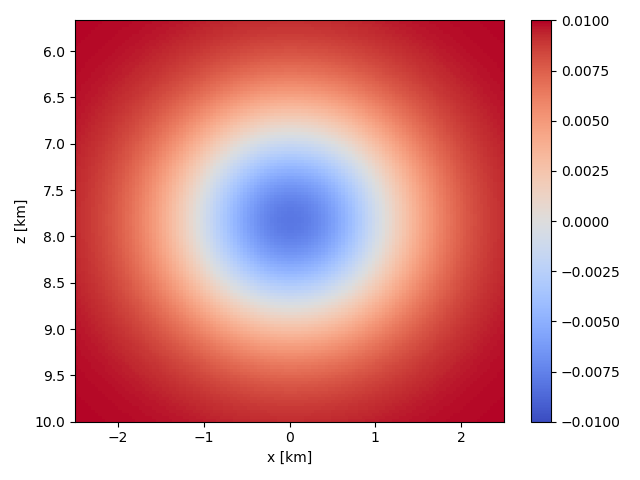

In [14]:
plt.figure()
plt.pcolormesh(x * 1e-3, z * 1e-3, (p.mesh_dict["A"] - p.mesh_dict["B"]).reshape(X.shape), 
               vmin=-0.01, vmax=0.01, cmap="coolwarm")
plt.colorbar()
plt.xlabel("x [km]")
plt.ylabel("z [km]")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

As desired, the asperity is defined by $(a-b) < 0$, embedded in a stable matrix with $(a-b) > 0$.

The `p.write()` command writes a `qdyn.in` file to the current working directory, which is read by QDYN at the start of the simulation. To do this, call `p.run()`. Note that in this notebook, the screen output (`stdout`) is captured by the console, so you won't see any output here.

In [9]:
p.run()

0

During the simulation, output is flushed to disk every `NTOUT` time steps. This output can be reloaded without re-running the simulation, so you only have to call `p.run()` again if you made any changes to the input parameters. To read/process the output, call:

In [10]:
p.read_output(read_ot=True, read_ox=True)

True

Instead of using an auxiliary library of plotting functions (`plot_functions.py`), we can directly access the time series output from `p.ot` to plot the slip rate and shear stress in the middle of the fault:

<IPython.core.display.Javascript object>


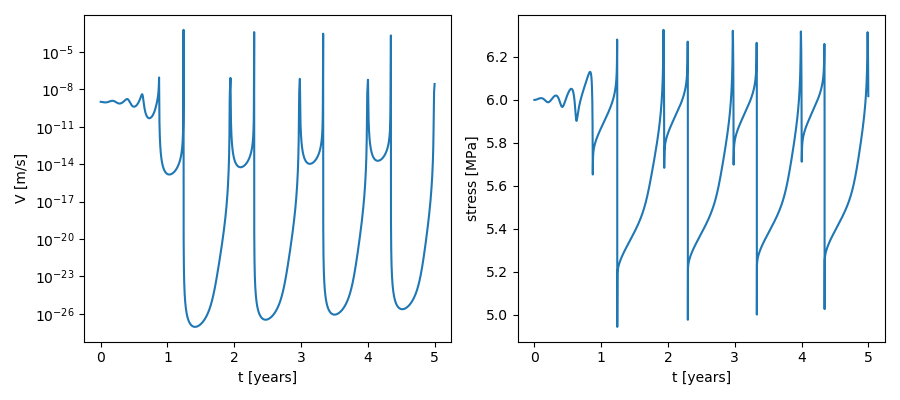

In [13]:
# Time-series plot at the middle of the fault
plt.figure(figsize=(9, 4))

# Slip rate
plt.subplot(121)
plt.plot(p.ot[0]["t"] / t_yr, p.ot[0]["v"])
plt.xlabel("t [years]")
plt.ylabel("V [m/s]")
plt.yscale("log")

# Shear stress
plt.subplot(122)
plt.plot(p.ot[0]["t"] / t_yr, p.ot[0]["tau"] * 1e-6)
plt.xlabel("t [years]")
plt.ylabel("stress [MPa]")

plt.tight_layout()
plt.show()

Similarly, we can access individual snapshots from `p.ox`:

<IPython.core.display.Javascript object>


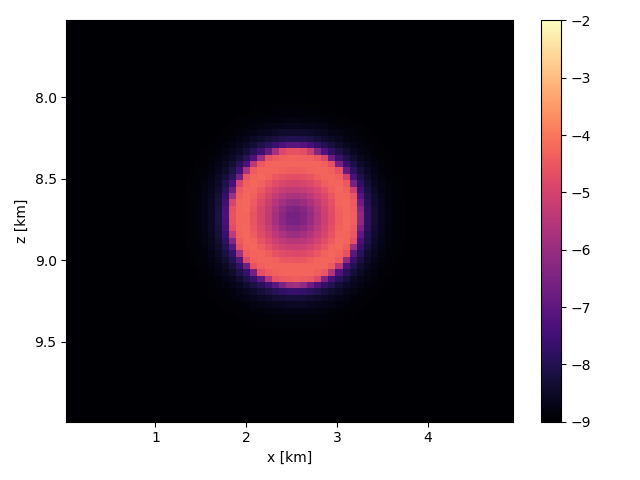

In [40]:
# Get the x, z coordinates of the fault
x_ox = p.ox["x"].unique()
z_ox = p.ox["z"].unique()

X, Z = np.meshgrid(x_ox, z_ox)

# Number of snapshots
Nt = len(p.ox["v"]) // (len(x_ox) * len(z_ox))

# Get velocity snapshots
V_ox = p.ox["v"].values.reshape((Nt, len(z_ox), len(x_ox)))

# Plot one snapshot of slip rate
plt.figure()

plt.pcolormesh(x_ox * 1e-3, -z_ox * 1e-3, np.log10(V_ox[14]), cmap="magma", vmin=-9, vmax=-2)
plt.xlabel("x [km]")
plt.ylabel("z [km]")

plt.gca().invert_yaxis()
plt.colorbar()

plt.tight_layout()
plt.show()